In [1]:
%matplotlib inline
import xarray as xr
import dask
import s3fs

# http://54.66.163.19

# LocalCluster

In [32]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36779")
client

Client Scheduler: tcp://127.0.0.1:36779 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 96 Memory: 397.04 GB


# S3 Buckets

In [33]:
s3 = s3fs.S3FileSystem(key='...', 
                       secret='<snip>')

In [4]:
s3.ls('csiro-dcfp/CAFE/forecasts/f4')

['csiro-dcfp/CAFE/forecasts/f4/run.sh',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19611101',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19621101',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19631101',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19641101',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19651101',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19661101',
 'csiro-dcfp/CAFE/forecasts/f4/log']

In [5]:
s3.ls('csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001')[:5]

['csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1960_11_01.nc',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1960_11_02.nc',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1960_11_03.nc',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1960_11_04.nc',
 'csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1960_11_05.nc']

In [6]:
s3.get('csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1960_11_01.nc',
       'atmos_daily_1960_11_01.nc')

In [7]:
ds = xr.open_dataset('atmos_daily_1960_11_01.nc')
ds.temp

<xarray.DataArray 'temp' (time: 1, pfull: 24, lat: 90, lon: 144)>
[311040 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * time     (time) object 1960-11-01 12:00:00
  * pfull    (pfull) float64 3.65 19.09 52.34 99.13 ... 963.1 976.5 987.4 996.1
Attributes:
    long_name:      temperature
    units:          deg_K
    valid_range:    [100. 350.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

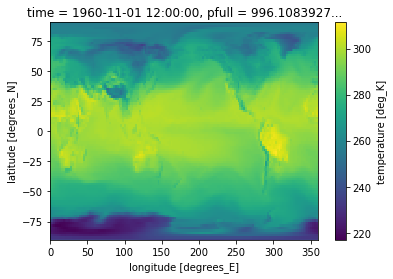

In [8]:
ds.temp.isel(time=0, pfull=-1).plot()

## Mount S3 buckets as a FUSE filesystem

In [ ]:
!goofys csiro-dcfp csiro-dcfp
!goofys imos-data imos-data

S3 Fuse file systems work with globs (*.nc)

In [34]:
ds = xr.open_dataset('csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1961_11_01.nc')
ds.temp

<xarray.DataArray 'temp' (time: 1, pfull: 24, lat: 90, lon: 144)>
[311040 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * time     (time) object 1961-11-01 12:00:00
  * pfull    (pfull) float64 3.65 19.09 52.34 99.13 ... 963.1 976.5 987.4 996.1
Attributes:
    long_name:      temperature
    units:          deg_K
    valid_range:    [100. 350.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [35]:
%%time
ds = xr.open_mfdataset('csiro-dcfp/CAFE/forecasts/f4/c5-d60-pX-f4-19601101/mem001/atmos_daily_1964_*.nc',
                      parallel=True)
ds.temp

CPU times: user 4.85 s, sys: 103 ms, total: 4.95 s
Wall time: 8.99 s


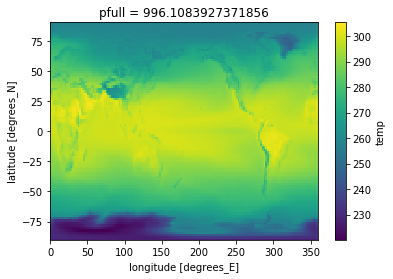

In [36]:
temp_mean = ds.temp.isel(pfull=-1).mean('time')
temp_mean.plot()

In [38]:
%%time
s3map = s3fs.S3Map('s3://csiro-dcfp/atmos_daily_1964_temp_2', s3=s3)
ds_temp_in = ds.temp.to_dataset()
ds_temp_in.to_zarr(s3map, mode='w')

CPU times: user 1.02 s, sys: 36.6 ms, total: 1.05 s
Wall time: 4.62 s


In [31]:
%%time
ds_temp_out = xr.open_zarr(s3map)
ds_temp_out

CPU times: user 3.31 s, sys: 132 ms, total: 3.44 s
Wall time: 8.76 s


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


## Intake catalog

In [39]:
import intake
catalog_url = 'https://github.com/pangeo-data/pangeo/raw/master/gce/catalog.yaml'
gmet_v1 = intake.Catalog(catalog_url).gmet_v1.to_dask()

/opt/tljh/user/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
mean_temp = gmet_v1.t_mean.mean((['time', 'ensemble']))